# Backtesting of predctions

## Author: Danilo Filippo Reiszel Pereira
Univesidade Federal do Rio de Janeiro

This notebook contains the creation a Multi-layer Perceptron model to predict D+1 closing prices of PETR4 stocks, using as input 10 delays of its return series and some auxiliary series, with backtesting of the predictions

In [1]:
from __future__ import print_function, division
import sys, os
sys.path.append('../../src')
import time 
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralstocks.dataacquisition import *
from neuralstocks.plots import *
from neuralstocks.utils import *

%matplotlib inline

# Global Params
Setting global params and useful variables, such as directories and image styling

In [2]:
saveFigDir = './Figures'
os.makedirs(saveFigDir) if not os.path.exists(saveFigDir) else print('', end='\r')

pathPETR4_MLP = '../MLP/residuals/PETR4/Variables/PETR4_MLP_predicted.CSV'
pathITUB4_MLP = '../MLP/residuals/ITUB4/Variables/ITUB4_MLP_predicted.CSV'
pathVALE5_MLP = '../MLP/residuals/VALE5/Variables/VALE5_MLP_predicted.CSV'
pathABEV3_MLP = '../MLP/residuals/ABEV3/Variables/ABEV3_MLP_predicted.CSV'

pathPETR4_SAE = '../StackedAutoEncoder/residuals/PETR4/Variables/PETR4_SAE_predicted.CSV'
pathITUB4_SAE = '../StackedAutoEncoder/residuals/ITUB4/Variables/ITUB4_SAE_predicted.CSV'
pathVALE5_SAE = '../StackedAutoEncoder/residuals/VALE5/Variables/VALE5_SAE_predicted.CSV'
pathABEV3_SAE = '../StackedAutoEncoder/residuals/ABEV3/Variables/ABEV3_SAE_predicted.CSV'

plt.rcParams['font.weight'] = 'bold'
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

## Data Acquisition

In [4]:
init_time = time.time()

PETR4_MLP = pd.read_csv(pathPETR4_MLP, parse_dates=['Date'], index_col='Date').sort_index()
ITUB4_MLP = pd.read_csv(pathITUB4_MLP, parse_dates=['Date'], index_col='Date').sort_index()
VALE5_MLP = pd.read_csv(pathVALE5_MLP, parse_dates=['Date'], index_col='Date').sort_index()
ABEV3_MLP = pd.read_csv(pathABEV3_MLP, parse_dates=['Date'], index_col='Date').sort_index()

PETR4_SAE = pd.read_csv(pathPETR4_SAE, parse_dates=['Date'], index_col='Date').sort_index()[['PETR4_Close_predicted_SAEnorm', 'PETR4_Close_predicted_SAEstd']]
ITUB4_SAE = pd.read_csv(pathITUB4_SAE, parse_dates=['Date'], index_col='Date').sort_index()[['ITUB4_Close_predicted_SAEnorm', 'ITUB4_Close_predicted_SAEstd']]
VALE5_SAE = pd.read_csv(pathVALE5_SAE, parse_dates=['Date'], index_col='Date').sort_index()[['VALE5_Close_predicted_SAEnorm', 'VALE5_Close_predicted_SAEstd']]
ABEV3_SAE = pd.read_csv(pathABEV3_SAE, parse_dates=['Date'], index_col='Date').sort_index()[['ABEV3_Close_predicted_SAEnorm', 'ABEV3_Close_predicted_SAEstd']]


PETR4_MLP = PETR4_MLP[['PETR4_Close', 'PETR4_Open', 'PETR4_High', 'PETR4_Low', 'PETR4_Volume', 
               'PETR4_Close_trend', 'PETR4_Close_resid', 'PETR4_Close_predicted_MLPnorm', 'PETR4_Close_predicted_MLPstd']]
ITUB4_MLP = ITUB4_MLP[['ITUB4_Close', 'ITUB4_Open', 'ITUB4_High', 'ITUB4_Low', 'ITUB4_Volume', 
               'ITUB4_Close_trend', 'ITUB4_Close_resid', 'ITUB4_Close_predicted_MLPnorm', 'ITUB4_Close_predicted_MLPstd']]
VALE5_MLP = VALE5_MLP[['VALE5_Close', 'VALE5_Open', 'VALE5_High', 'VALE5_Low', 'VALE5_Volume', 
               'VALE5_Close_trend', 'VALE5_Close_resid', 'VALE5_Close_predicted_MLPnorm', 'VALE5_Close_predicted_MLPstd']]
ABEV3_MLP = ABEV3_MLP[['ABEV3_Close', 'ABEV3_Open', 'ABEV3_High', 'ABEV3_Low', 'ABEV3_Volume', 
               'ABEV3_Close_trend', 'ABEV3_Close_resid', 'ABEV3_Close_predicted_MLPnorm', 'ABEV3_Close_predicted_MLPstd']]

df = pd.concat([PETR4_MLP, PETR4_SAE, ITUB4_MLP, ITUB4_SAE, VALE5_MLP, VALE5_SAE, ABEV3_MLP, ABEV3_SAE], axis = 1)

end_time = time.time()
print('Time to acquire and process data: '+str(end_time-init_time)+' seconds')

Time to acquire and process data: 0.576090097427 seconds


In [5]:
df.columns

Index([u'PETR4_Close', u'PETR4_Open', u'PETR4_High', u'PETR4_Low',
       u'PETR4_Volume', u'PETR4_Close_trend', u'PETR4_Close_resid',
       u'PETR4_Close_predicted_MLPnorm', u'PETR4_Close_predicted_MLPstd',
       u'PETR4_Close_predicted_SAEnorm', u'PETR4_Close_predicted_SAEstd',
       u'ITUB4_Close', u'ITUB4_Open', u'ITUB4_High', u'ITUB4_Low',
       u'ITUB4_Volume', u'ITUB4_Close_trend', u'ITUB4_Close_resid',
       u'ITUB4_Close_predicted_MLPnorm', u'ITUB4_Close_predicted_MLPstd',
       u'ITUB4_Close_predicted_SAEnorm', u'ITUB4_Close_predicted_SAEstd',
       u'VALE5_Close', u'VALE5_Open', u'VALE5_High', u'VALE5_Low',
       u'VALE5_Volume', u'VALE5_Close_trend', u'VALE5_Close_resid',
       u'VALE5_Close_predicted_MLPnorm', u'VALE5_Close_predicted_MLPstd',
       u'VALE5_Close_predicted_SAEnorm', u'VALE5_Close_predicted_SAEstd',
       u'ABEV3_Close', u'ABEV3_Open', u'ABEV3_High', u'ABEV3_Low',
       u'ABEV3_Volume', u'ABEV3_Close_trend', u'ABEV3_Close_resid',
       u'ABEV3_C

In [6]:
p = ('2017', '2017')
print('PETR4 trend           prediction RMSE: {:.5f}'.format(calculateRMSE(df['PETR4_Close'][p[0]:p[1]], df['PETR4_Close_trend'][p[0]:p[1]]).sum()))
print('PETR4 trend + ANNnorm prediction RMSE: {:.5f}'.format(calculateRMSE(df['PETR4_Close'][p[0]:p[1]], df['PETR4_Close_predicted_MLPnorm'][p[0]:p[1]]).sum()))
print('PETR4 trend + ANNstd  prediction RMSE: {:.5f}'.format(calculateRMSE(df['PETR4_Close'][p[0]:p[1]], df['PETR4_Close_predicted_MLPstd'][p[0]:p[1]]).sum()))
print('PETR4 trend + SAEnorm prediction RMSE: {:.5f}'.format(calculateRMSE(df['PETR4_Close'][p[0]:p[1]], df['PETR4_Close_predicted_SAEnorm'][p[0]:p[1]]).sum()))
print('PETR4 trend + SAEstd  prediction RMSE: {:.5f}'.format(calculateRMSE(df['PETR4_Close'][p[0]:p[1]], df['PETR4_Close_predicted_SAEstd'][p[0]:p[1]]).sum()))
print('----------------------------------------------')
print('PETR4 trend           prediction MAE:  {:.5f}'.format(calculateMAE(df['PETR4_Close'][p[0]:p[1]], df['PETR4_Close_trend'][p[0]:p[1]]).sum()))
print('PETR4 trend + ANNnorm prediction MAE:  {:.5f}'.format(calculateMAE(df['PETR4_Close'][p[0]:p[1]], df['PETR4_Close_predicted_MLPnorm'][p[0]:p[1]]).sum()))
print('PETR4 trend + ANNstd  prediction MAE:  {:.5f}'.format(calculateMAE(df['PETR4_Close'][p[0]:p[1]], df['PETR4_Close_predicted_MLPstd'][p[0]:p[1]]).sum()))
print('PETR4 trend + SAEnorm prediction MAE:  {:.5f}'.format(calculateMAE(df['PETR4_Close'][p[0]:p[1]], df['PETR4_Close_predicted_SAEnorm'][p[0]:p[1]]).sum()))
print('PETR4 trend + SAEstd  prediction MAE:  {:.5f}'.format(calculateMAE(df['PETR4_Close'][p[0]:p[1]], df['PETR4_Close_predicted_SAEstd'][p[0]:p[1]]).sum()))

PETR4 trend           prediction RMSE: 0.38450
PETR4 trend + ANNnorm prediction RMSE: 0.36008
PETR4 trend + ANNstd  prediction RMSE: 0.37231
PETR4 trend + SAEnorm prediction RMSE: 0.37632
PETR4 trend + SAEstd  prediction RMSE: 0.37207
----------------------------------------------
PETR4 trend           prediction MAE:  0.27122
PETR4 trend + ANNnorm prediction MAE:  0.25229
PETR4 trend + ANNstd  prediction MAE:  0.27311
PETR4 trend + SAEnorm prediction MAE:  0.27027
PETR4 trend + SAEstd  prediction MAE:  0.26678


In [7]:
p = ('2017', '2017')
print('ITUB4 trend           prediction RMSE: {:.5f}'.format(calculateRMSE(df['ITUB4_Close'][p[0]:p[1]], df['ITUB4_Close_trend'][p[0]:p[1]]).sum()))
print('ITUB4 trend + ANNnorm prediction RMSE: {:.5f}'.format(calculateRMSE(df['ITUB4_Close'][p[0]:p[1]], df['ITUB4_Close_predicted_MLPnorm'][p[0]:p[1]]).sum()))
print('ITUB4 trend + ANNstd  prediction RMSE: {:.5f}'.format(calculateRMSE(df['ITUB4_Close'][p[0]:p[1]], df['ITUB4_Close_predicted_MLPstd'][p[0]:p[1]]).sum()))
print('ITUB4 trend + SAEnorm prediction RMSE: {:.5f}'.format(calculateRMSE(df['ITUB4_Close'][p[0]:p[1]], df['ITUB4_Close_predicted_SAEnorm'][p[0]:p[1]]).sum()))
print('ITUB4 trend + SAEstd  prediction RMSE: {:.5f}'.format(calculateRMSE(df['ITUB4_Close'][p[0]:p[1]], df['ITUB4_Close_predicted_SAEstd'][p[0]:p[1]]).sum()))
print('----------------------------------------------')
print('ITUB4 trend           prediction MAE:  {:.5f}'.format(calculateMAE(df['ITUB4_Close'][p[0]:p[1]], df['ITUB4_Close_trend'][p[0]:p[1]]).sum()))
print('ITUB4 trend + ANNnorm prediction MAE:  {:.5f}'.format(calculateMAE(df['ITUB4_Close'][p[0]:p[1]], df['ITUB4_Close_predicted_MLPnorm'][p[0]:p[1]]).sum()))
print('ITUB4 trend + ANNstd  prediction MAE:  {:.5f}'.format(calculateMAE(df['ITUB4_Close'][p[0]:p[1]], df['ITUB4_Close_predicted_MLPstd'][p[0]:p[1]]).sum()))
print('ITUB4 trend + SAEnorm prediction MAE:  {:.5f}'.format(calculateMAE(df['ITUB4_Close'][p[0]:p[1]], df['ITUB4_Close_predicted_SAEnorm'][p[0]:p[1]]).sum()))
print('ITUB4 trend + SAEstd  prediction MAE:  {:.5f}'.format(calculateMAE(df['ITUB4_Close'][p[0]:p[1]], df['ITUB4_Close_predicted_SAEstd'][p[0]:p[1]]).sum()))

ITUB4 trend           prediction RMSE: 0.70200
ITUB4 trend + ANNnorm prediction RMSE: 0.62539
ITUB4 trend + ANNstd  prediction RMSE: 0.64176
ITUB4 trend + SAEnorm prediction RMSE: 0.67725
ITUB4 trend + SAEstd  prediction RMSE: 0.67907
----------------------------------------------
ITUB4 trend           prediction MAE:  0.48417
ITUB4 trend + ANNnorm prediction MAE:  0.42006
ITUB4 trend + ANNstd  prediction MAE:  0.42683
ITUB4 trend + SAEnorm prediction MAE:  0.45108
ITUB4 trend + SAEstd  prediction MAE:  0.46429


In [8]:
p = ('2017', '2017')
print('VALE5 trend           prediction RMSE: {:.5f}'.format(calculateRMSE(df['VALE5_Close'][p[0]:p[1]], df['VALE5_Close_trend'][p[0]:p[1]]).sum()))
print('VALE5 trend + ANNnorm prediction RMSE: {:.5f}'.format(calculateRMSE(df['VALE5_Close'][p[0]:p[1]], df['VALE5_Close_predicted_MLPnorm'][p[0]:p[1]]).sum()))
print('VALE5 trend + ANNstd  prediction RMSE: {:.5f}'.format(calculateRMSE(df['VALE5_Close'][p[0]:p[1]], df['VALE5_Close_predicted_MLPstd'][p[0]:p[1]]).sum()))
print('VALE5 trend + SAEnorm prediction RMSE: {:.5f}'.format(calculateRMSE(df['VALE5_Close'][p[0]:p[1]], df['VALE5_Close_predicted_SAEnorm'][p[0]:p[1]]).sum()))
print('VALE5 trend + SAEstd  prediction RMSE: {:.5f}'.format(calculateRMSE(df['VALE5_Close'][p[0]:p[1]], df['VALE5_Close_predicted_SAEstd'][p[0]:p[1]]).sum()))
print('----------------------------------------------')
print('VALE5 trend           prediction MAE:  {:.5f}'.format(calculateMAE(df['VALE5_Close'][p[0]:p[1]], df['VALE5_Close_trend'][p[0]:p[1]]).sum()))
print('VALE5 trend + ANNnorm prediction MAE:  {:.5f}'.format(calculateMAE(df['VALE5_Close'][p[0]:p[1]], df['VALE5_Close_predicted_MLPnorm'][p[0]:p[1]]).sum()))
print('VALE5 trend + ANNstd  prediction MAE:  {:.5f}'.format(calculateMAE(df['VALE5_Close'][p[0]:p[1]], df['VALE5_Close_predicted_MLPstd'][p[0]:p[1]]).sum()))
print('VALE5 trend + SAEnorm prediction MAE:  {:.5f}'.format(calculateMAE(df['VALE5_Close'][p[0]:p[1]], df['VALE5_Close_predicted_SAEnorm'][p[0]:p[1]]).sum()))
print('VALE5 trend + SAEstd  prediction MAE:  {:.5f}'.format(calculateMAE(df['VALE5_Close'][p[0]:p[1]], df['VALE5_Close_predicted_SAEstd'][p[0]:p[1]]).sum()))

VALE5 trend           prediction RMSE: 0.82310
VALE5 trend + ANNnorm prediction RMSE: 0.74398
VALE5 trend + ANNstd  prediction RMSE: 0.76802
VALE5 trend + SAEnorm prediction RMSE: 0.79818
VALE5 trend + SAEstd  prediction RMSE: 0.78071
----------------------------------------------
VALE5 trend           prediction MAE:  0.63796
VALE5 trend + ANNnorm prediction MAE:  0.57929
VALE5 trend + ANNstd  prediction MAE:  0.58386
VALE5 trend + SAEnorm prediction MAE:  0.62562
VALE5 trend + SAEstd  prediction MAE:  0.60840


In [9]:
p = ('2017', '2017')
print('ABEV3 trend           prediction RMSE: {:.5f}'.format(calculateRMSE(df['ABEV3_Close'][p[0]:p[1]], df['ABEV3_Close_trend'][p[0]:p[1]]).sum()))
print('ABEV3 trend + ANNnorm prediction RMSE: {:.5f}'.format(calculateRMSE(df['ABEV3_Close'][p[0]:p[1]], df['ABEV3_Close_predicted_MLPnorm'][p[0]:p[1]]).sum()))
print('ABEV3 trend + ANNstd  prediction RMSE: {:.5f}'.format(calculateRMSE(df['ABEV3_Close'][p[0]:p[1]], df['ABEV3_Close_predicted_MLPstd'][p[0]:p[1]]).sum()))
print('ABEV3 trend + SAEnorm prediction RMSE: {:.5f}'.format(calculateRMSE(df['ABEV3_Close'][p[0]:p[1]], df['ABEV3_Close_predicted_SAEnorm'][p[0]:p[1]]).sum()))
print('ABEV3 trend + SAEstd  prediction RMSE: {:.5f}'.format(calculateRMSE(df['ABEV3_Close'][p[0]:p[1]], df['ABEV3_Close_predicted_SAEstd'][p[0]:p[1]]).sum()))
print('----------------------------------------------')
print('ABEV3 trend           prediction MAE:  {:.5f}'.format(calculateMAE(df['ABEV3_Close'][p[0]:p[1]], df['ABEV3_Close_trend'][p[0]:p[1]]).sum()))
print('ABEV3 trend + ANNnorm prediction MAE:  {:.5f}'.format(calculateMAE(df['ABEV3_Close'][p[0]:p[1]], df['ABEV3_Close_predicted_MLPnorm'][p[0]:p[1]]).sum()))
print('ABEV3 trend + ANNstd  prediction MAE:  {:.5f}'.format(calculateMAE(df['ABEV3_Close'][p[0]:p[1]], df['ABEV3_Close_predicted_MLPstd'][p[0]:p[1]]).sum()))
print('ABEV3 trend + SAEnorm prediction MAE:  {:.5f}'.format(calculateMAE(df['ABEV3_Close'][p[0]:p[1]], df['ABEV3_Close_predicted_SAEnorm'][p[0]:p[1]]).sum()))
print('ABEV3 trend + SAEstd  prediction MAE:  {:.5f}'.format(calculateMAE(df['ABEV3_Close'][p[0]:p[1]], df['ABEV3_Close_predicted_SAEstd'][p[0]:p[1]]).sum()))

ABEV3 trend           prediction RMSE: 0.25765
ABEV3 trend + ANNnorm prediction RMSE: 0.19535
ABEV3 trend + ANNstd  prediction RMSE: 0.19892
ABEV3 trend + SAEnorm prediction RMSE: 0.23403
ABEV3 trend + SAEstd  prediction RMSE: 0.24068
----------------------------------------------
ABEV3 trend           prediction MAE:  0.19020
ABEV3 trend + ANNnorm prediction MAE:  0.14273
ABEV3 trend + ANNstd  prediction MAE:  0.14107
ABEV3 trend + SAEnorm prediction MAE:  0.17610
ABEV3 trend + SAEstd  prediction MAE:  0.17908


In [10]:
from __future__ import division
import random
from collections import defaultdict
from datetime import timedelta

from matplotlib.ticker import EngFormatter

class Backtest:
    oneDay = timedelta(days = 1)
    
    def __init__(self, assets, dataPath = '../../../data/stocks/[asset]/diario/[asset].CSV', initialFunds = 100000, 
                 brokerage = 6.0, transactionFees = 0.000325, ISStax = 0.05):
        self.assets = assets
        self.dataPath = dataPath
        self.funds = initialFunds
        self.initialFunds = initialFunds
        self.brokerage = brokerage
        self.transactionFees = transactionFees
        self.ISStax = ISStax
        
        self.history = {}
        self.dailyData = {}
        self.verbose = 0;
        self.shortedFunds = 0
        self.pendingOperations = []
        self.openPositions = []
        self.strategy = ''
        self.predictedValues = {}
        
        self.useRiskManagement = False
        self.stopLoss = None
        self.stopGain = None
        self.maxExposure = None
        self.maxTotalExposure = None
        
        self.loadData()
        
    def setRiskManagement(self, stopLoss = None, stopGain = None, maxExposure = None, maxTotalExposure = None, useRiskManagement = True):
        self.useRiskManagement = useRiskManagement
        self.stopLoss = stopLoss
        self.stopGain = stopGain
        self.maxExposure = maxExposure
        self.maxTotalExposure = maxTotalExposure
        
    def loadData(self):
        for asset in self.assets:
            filePath = self.dataPath.replace('[asset]', asset)
            df = pd.read_csv(filePath, delimiter=';', decimal=',',
                     parse_dates=['Date'], dayfirst=True, index_col='Date').sort_index()
            self.dailyData[asset] = df
    
    def simulate(self, initialFunds, strategy = 'buy-n-hold', start = None, end = None, longOnly = False, predicted = None, simulationName = None, verbose = 0):
        simulationName = simulationName if simulationName else strategy
        print('Starting {} simulation with {}'.format(simulationName, self.assets))
        self.strategy = strategy
        self.funds = initialFunds
        self.initialFunds = initialFunds
        self.verbose = verbose
        if strategy == 'buy-n-hold':
            self.buyNHold(start, end)
        elif strategy == 'repeatLast':
            pass
        elif strategy == 'predicted':
            if predicted:
                for asset in self.assets:
                    if not asset in predicted:
                        print('Warning: No predictions for {}. This asset will be excluded from the simulation.'.format(asset))
                    else:
                        self.predictedValues[asset] = predicted[asset]
            if self.predictedValues:
                self.simulatePredicted(start, end, simulationName)
            else:
                print('No predicted values given for the selected assets')
            self.predictedValues = {}
        else:
            print('Selected strategy not recognized')
    
    def buyNHold(self, start, end):
        self.history['buy-n-hold'] = pd.DataFrame(index=self.dailyData[self.assets[0]][start:end].index, columns=['portfolioValue'])
        maxValue = self.funds / len(self.assets)
        random.shuffle(self.assets)
        date = self.dailyData[self.assets[0]][start:end].index[0]
        print('Portfolio value at start: {:.2f} BRL'.format(self.funds))
        previousPortfolioValue = self.funds
        #buy all
        for asset in self.assets:
            self.buy(asset = asset, date = self.dailyData[asset][start:end].index[0], limitValue = maxValue)
        #evaluate portfolio value for each trading day
        for d in self.dailyData[self.assets[0]][start:end].index:
            date = d
            self.history['buy-n-hold'].at[date, 'portfolioValue'] = self.evaluatePortfolio(date)
            if self.verbose >= 1:
                print('Portfolio value at {} market close: {:.2f} BRL'.format(date.strftime('%Y-%m-%d'), self.history['buy-n-hold']['portfolioValue'][date]))
        #sell all
        self.liquidateAll(date)
        print('Portfolio value at end: {:.2f} BRL'.format(self.funds))
        self.calculateDrawdown('buy-n-hold')
        
    def simulatePredicted(self, start, end, simulationName = 'predicted'):
        self.history[simulationName] = pd.DataFrame(index=self.dailyData[self.assets[0]][start:end].index, columns=['portfolioValue'])
        maxValue = self.funds / len(self.assets)
        date = self.dailyData[self.assets[0]][start:end].index[0]
        print('Portfolio value at start: {:.2f} BRL'.format(self.funds))
        # simulate for every day in the simulation period
        for d in self.dailyData[self.assets[0]][start:end].index:
            date = d
            self.decideOperations(date)
            self.executeOperations(maxValue)
            self.liquidateAll()
            self.history[simulationName].at[date, 'portfolioValue'] = self.evaluatePortfolio(date)
            if self.verbose >= 1:
                print('Portfolio value at {} market close: {:.2f} BRL'.format(date.strftime('%Y-%m-%d'), self.history[simulationName]['portfolioValue'][date]))
        print('Portfolio value at end: {:.2f} BRL'.format(self.funds))
        self.calculateDrawdown(simulationName)
             
    def decideOperations(self, date):
        for asset in self.assets:
            op = self.evaluateOperation(date, asset)
            if op == 'long' or op == 'short':
                self.pendingOperations.append(self.createPosition(asset, op, -1, -1, date))
            if op == 'skip':
                if self.verbose >= 2:
                    print('{} - Skipped {}, no profit predicted'.format(date.strftime('%Y-%m-%d'), asset))
                
    def evaluateOperation(self, date, asset):
        if  self.predictedValues[asset][date] > self.dailyData[asset]['Close'][:date][-2]:# + 0.05:
            return 'long'
        elif self.predictedValues[asset][date] < self.dailyData[asset]['Close'][:date][-2]:# - 0.05:
            return 'short'
        else:
            return 'skip'
        
    def executeOperations(self, maxValue):
        for i in range(len(self.pendingOperations)):
            op = self.pendingOperations.pop(0)
            if op['opType'] == 'long':
                self.buy(op['asset'], op['date'], limitValue = maxValue)
            elif op['opType'] == 'short':
                self.sell(op['asset'], op['date'], limitValue = maxValue)
                
    def liquidateAll(self, date = None):
        for i in range(len(self.openPositions)):
            pos = self.openPositions[0] # always 0 because entries will be popped by buy or sell operations
            if pos['opType'] == 'long':
                self.sell(pos['asset'], date = date)
            elif pos['opType'] == 'short':
                self.buy(pos['asset'], date = date)
    
    def buy(self, asset, date = None, volume = None, limitValue = None):
        # check if a short operation with this asset exists, liquidate if so
        if len(filter(lambda op: op['asset'] == asset and op['opType'] == 'short', self.openPositions)) > 0:
            operation = self.openPositions.pop(findIndex(self.openPositions, asset, lambda x, y: x['asset'] == y))
            date = date if date else operation['date']
            price = self.dailyData[asset]['Close'][date] - 0.01
            buyValue = operation['volume'] * price
            fees = self.brokerage + (buyValue * self.transactionFees) + (self.brokerage * self.ISStax)
            self.funds = self.funds - buyValue - fees
            if self.verbose >= 2:
                print('{} Close - Bought {} {} (shorted). price: {} BRL, fees: {:.2f}, total: {:.2f} BRL'.format(date.strftime('%Y-%m-%d'), operation['volume'], asset, price, fees, buyValue + fees))
        else: #longs the stock
            price = self.dailyData[asset]['Open'][date] + 0.01
            if not volume and not limitValue:
                print('{} - Error buying {} - Neither volume nor limitValue were specified'.format(date, asset))
            else:
                limitVolume = int(((limitValue/price)//100)*100)
                volume = volume if volume else limitVolume
                buyValue = volume * price
                fees = self.brokerage + (buyValue * self.transactionFees) + (self.brokerage * self.ISStax)
                self.openPositions.append(self.createPosition(asset, 'long', volume, price, date))
                self.funds = self.funds - buyValue - fees
                if self.verbose >= 2:
                    print('{} Open - Bought {} {}. price: {} BRL, fees: {:.2f}, total: {:.2f} BRL'.format(date.strftime('%Y-%m-%d'), volume, asset, price, fees, buyValue + fees))
                
    def sell(self, asset, date = None, volume = None, limitValue = None):
        # check if a long operation with this asset exists, liquidate if so
        if len(filter(lambda op: op['asset'] == asset and op['opType'] == 'long', self.openPositions)) > 0:
            operation = self.openPositions.pop(findIndex(self.openPositions, asset, lambda x, y: x['asset'] == y))
            date = date if date else operation['date']
            price = self.dailyData[asset]['Close'][date] - 0.01
            sellValue = operation['volume'] * price
            fees = self.brokerage + (sellValue * self.transactionFees) + (self.brokerage * self.ISStax)
            self.funds = self.funds + sellValue - fees
            if self.verbose >= 2:
                print('{} Close - Sold {} {}. price: {} BRL, fees: {:.2f}, total: {:.2f} BRL'.format(date.strftime('%Y-%m-%d'), operation['volume'], asset, price, fees, sellValue + fees))
        else: # shorts the stock
            price = self.dailyData[asset]['Open'][date] + 0.01
            if not volume and not limitValue:
                print('{} - Error shorting {} - Neither volume nor limitValue were specified'.format(date, asset))
            else:
                limitVolume = int(((limitValue/price)//100)*100)
                volume = volume if volume else limitVolume
                sellValue = volume * price
                fees = self.brokerage + (sellValue * self.transactionFees) + (self.brokerage * self.ISStax)
                self.openPositions.append(self.createPosition(asset, 'short', volume, price, date))
                self.funds = self.funds + sellValue - fees
                if self.verbose >= 2:
                    print('{} Open - Shorted {} {}. price: {} BRL, fees: {:.2f}, total: {:.2f} BRL'.format(date.strftime('%Y-%m-%d'), volume, asset, price, fees, sellValue + fees))
           
    def createPosition(self, asset, opType, volume, price, date = None):
        return {'asset': asset, 'opType': opType, 'volume': volume, 'price': price, 'date': date}
    
    def evaluatePortfolio(self, date, moment = 'Close'):
        portfolio = self.funds + self.shortedFunds
        for l in filter(lambda x: x['opType'] == 'long', self.openPositions):
            portfolio += l['volume'] * self.dailyData[l['asset']][moment][date]
        for s in filter(lambda x: x['opType'] == 'short', self.openPositions):
            portfolio -= s['volume'] * self.dailyData[s['asset']][moment][date]
        return portfolio

    def calculateDrawdown(self, simulationName):
        simulationName = simulationName if simulationName else self.strategy
        if self.history[simulationName] is not None and self.history[simulationName]['portfolioValue'] is not None:
            drawdown = (self.history[simulationName]['portfolioValue'] - np.maximum.accumulate(self.history[simulationName]['portfolioValue']))/np.maximum.accumulate(self.history[simulationName]['portfolioValue'])
            self.history[simulationName] = self.history[simulationName].assign(drawdown = drawdown)
            
    def plotSimulations(self, simulations = None, names = None, title = None, ylabel = None, initialPlotDate = None, finalPlotDate = None, figsize = (10,6), legendsize = 12, linestyle = '-', linewidth = 2.0, legendncol = 3, saveImg = False, saveDir = '', saveName = '', saveFormat = 'pdf'):
        if len(self.history) == 0:
            print('No saved simulations found!')
            return None
        initialPlotDate = self.history[self.history.keys()[0]]['portfolioValue'][initialPlotDate:].index[0]
        finalPlotDate = self.history[self.history.keys()[0]]['portfolioValue'][:finalPlotDate].index[-1]
        if not title:
            title = 'Portfolio Value'
        if not ylabel:
            ylabel = 'BRL'

        fig, ax = plt.subplots(figsize=figsize, nrows = 1, ncols = 1)
        fig.suptitle(title)
        ax.set_xlabel('Date')
        ax.set_ylabel(ylabel)
        simulationsToPlot = len(simulations) if simulations is not None else len(self.history)
        simulations = simulations if simulations is not None else list(self.history.keys())
        if names is None:
            names = simulations
        formatter = EngFormatter(unit='')
        ax.yaxis.set_major_formatter(formatter)
        for i in range(simulationsToPlot):
            s = self.history[simulations[i]]['portfolioValue']
            d = pd.date_range(start=s[initialPlotDate:finalPlotDate].index[0], end=s[initialPlotDate:finalPlotDate].index[-1], freq="B")
            ax.plot(np.arange(len(s[initialPlotDate:finalPlotDate])), s[initialPlotDate:finalPlotDate], linestyle, label = names[i], linewidth = linewidth)
            xticks = ax.get_xticks()
            ax.set_xticks(xticks)
            xticklabels = [(d[0] + x).strftime('%Y-%m') for x in xticks.astype(int)]
            ax.set_xticklabels(xticklabels)
        ax.plot(np.arange(len(s[initialPlotDate:finalPlotDate])), self.initialFunds * np.ones(np.arange(len(s[initialPlotDate:finalPlotDate])).shape), 'k--', linewidth=linewidth)
        ax.autoscale(True, axis='x')
        fig.autofmt_xdate()
        ax.grid()
        plt.legend(bbox_to_anchor=(0., 1.00, 1., .102), loc=3, ncol=legendncol, mode="expand", borderaxespad=0., prop={'size': legendsize}, frameon=False)
        if saveImg:
            saveName = saveName if saveName else '{}'.format(s[0].name)
            fig.savefig('{}/{}.{}'.format(saveDir, saveName, saveFormat), bbox_inches='tight')
        return fig, ax
            
    
class Position:
    asset_index = defaultdict(object)
    
    def __init__(self, asset, opType, volume, price, date = None):
        self.asset = asset
        self.opType = opType
        self.volume = volume
        self.price = price
        self.date = date
        Position.asset_index[asset] = self
    
    def __getitem__(self, key):
        if key == 'asset':
            return self.asset
        elif key == 'opType':
            return self.opType
        elif key == 'volume':
            return self.volume
        elif key == 'price':
            return self.price
        elif key == 'date':
            return self.date
        else:
            return None
        
    @classmethod
    def findByAsset(cls, asset):
        return Position.asset_index[asset]

    @classmethod
    def getByAsset(cls, asset):
        return Position.asset_index.pop(asset, None)

def findIndex(array, obj, func):
    for i in range(len(array)):
        if func(array[i], obj):
            return i
    return -1

In [11]:
#bt = Backtest(assets = ['PETR4', 'ITUB4', 'VALE5', 'ABEV3'], dataPath = '../../../data/stocks/[asset]/diario/[asset].CSV')
#bt = Backtest(assets = ['PETR4'], dataPath = '../../../data/stocks/[asset]/diario/[asset].CSV')
#bt = Backtest(assets = ['ITUB4'], dataPath = '../../../data/stocks/[asset]/diario/[asset].CSV')
#bt = Backtest(assets = ['VALE5'], dataPath = '../../../data/stocks/[asset]/diario/[asset].CSV')
bt = Backtest(assets = ['ABEV3'], dataPath = '../../../data/stocks/[asset]/diario/[asset].CSV')

Starting buy-n-hold simulation with ['ABEV3']
Portfolio value at start: 100000.00 BRL
Portfolio value at end: 121937.25 BRL
Starting predicted_trend simulation with ['ABEV3']
Portfolio value at start: 100000.00 BRL
Portfolio value at end: 85968.00 BRL
Starting predicted_mlp simulation with ['ABEV3']
Portfolio value at start: 100000.00 BRL
Portfolio value at end: 97124.00 BRL
Starting predicted_sae simulation with ['ABEV3']
Portfolio value at start: 100000.00 BRL
Portfolio value at end: 88826.00 BRL
Starting predicted_perfect simulation with ['ABEV3']
Portfolio value at start: 100000.00 BRL
Portfolio value at end: 183346.94 BRL


(<matplotlib.figure.Figure at 0x7fb6f84e0250>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb6f84e8d50>)

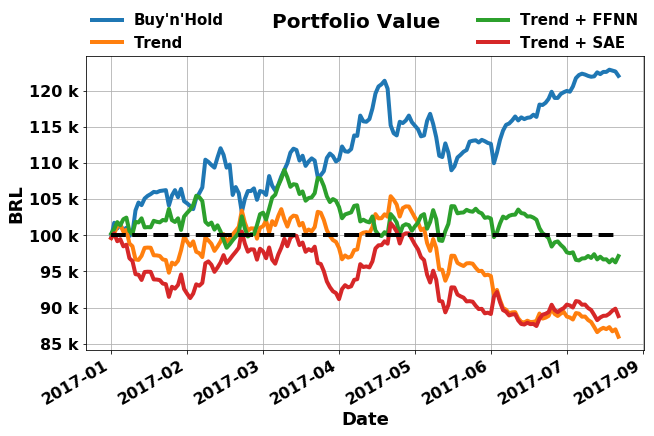

In [23]:
initialFunds = 100000

bt.simulate(strategy = 'buy-n-hold', start = '2017', initialFunds = initialFunds, verbose = 0)

bt.simulate(strategy = 'predicted', start = '2017', initialFunds = initialFunds, 
            predicted = {#'PETR4': df['PETR4_Close_trend'],
                         #'ITUB4': df['ITUB4_Close_trend'],
                         #'VALE5': df['VALE5_Close_trend'],
                         'ABEV3': df['ABEV3_Close_trend']
                        },
            simulationName = 'predicted_trend', verbose = 0)

bt.simulate(strategy = 'predicted', start = '2017', initialFunds = initialFunds, 
            predicted = {#'PETR4': df['PETR4_Close_predicted_MLPstd'],
                         #'PETR4': (df['PETR4_Close_trend'] + df['PETR4_Close_predicted_MLPstd'])/2,
                         #'ITUB4': df['ITUB4_Close_predicted_MLPstd'],
                         #'ITUB4': (df['ITUB4_Close_trend'] + df['ITUB4_Close_predicted_MLPstd'])/2,
                         #'VALE5': df['VALE5_Close_predicted_MLPstd'],
                         #'VALE5': (df['VALE5_Close_trend'] + df['VALE5_Close_predicted_MLPstd'])/2,
                         'ABEV3': df['ABEV3_Close_predicted_MLPstd'],
                         #'ABEV3': (df['ABEV3_Close_trend'] + df['ABEV3_Close_predicted_MLPstd'])/2
                        },
            simulationName = 'predicted_mlp', verbose = 0)

bt.simulate(strategy = 'predicted', start = '2017', initialFunds = initialFunds, 
            predicted = {#'PETR4': df['PETR4_Close_predicted_SAEstd'],
                         #'PETR4': (df['PETR4_Close_trend'] + df['PETR4_Close_predicted_SAEstd'])/2,
                         #'ITUB4': df['ITUB4_Close_predicted_SAEnorm'],
                         #'ITUB4': (df['ITUB4_Close_trend'] + df['ITUB4_Close_predicted_SAEstd'])/2,
                         #'VALE5': df['VALE5_Close_predicted_SAEstd'],
                         #'VALE5': (df['VALE5_Close_predicted_SAEstd'] + df['VALE5_Close_predicted_SAEstd'])/2,
                         'ABEV3': df['ABEV3_Close_predicted_SAEnorm'],
                         #'ABEV3': (df['ABEV3_Close_predicted_SAEstd'] + df['ABEV3_Close_predicted_SAEstd'])/2
                        },
            simulationName = 'predicted_sae', verbose = 0)

bt.simulate(strategy = 'predicted', start = '2017', initialFunds = initialFunds, 
            predicted = {
                         #'PETR4': df['PETR4_Close'], 
                         #'ITUB4': df['ITUB4_Close'],
                         #'VALE5': df['VALE5_Close'],
                         'ABEV3': df['ABEV3_Close']
                        }, 
            simulationName = 'predicted_perfect', verbose = 0)



bt.plotSimulations(simulations = ['buy-n-hold', 'predicted_trend', 'predicted_mlp', 'predicted_sae'],
                   names = ['Buy\'n\'Hold', 'Trend', 'Trend + FFNN', 'Trend + SAE'], 
                   legendsize = 15, linewidth = 4.0, figsize = (10,6), linestyle = '-', legendncol = 2,
                   saveImg = False, saveDir = saveFigDir, saveName = 'PETR4_backtest_ANNstd_SAEstd', saveFormat = 'pdf'
                  )

In [18]:
print('-------------------------------------')
print('Buy\'n\'Hold   final value:   {:.2f}'.format(bt.history['buy-n-hold']['portfolioValue'][-1]))
print('Buy\'n\'Hold   total profit:  {:.2f}%'.format(100*((bt.history['buy-n-hold']['portfolioValue'][-1] - bt.initialFunds)/bt.initialFunds)))
print('Buy\'n\'Hold   maximum value: {:.2f}'.format(max(bt.history['buy-n-hold']['portfolioValue'])))
print('-------------------------------------')
print('Trend only   final value:   {:.2f}'.format(bt.history['predicted_trend']['portfolioValue'][-1]))
print('Trend only   total profit:  {:.2f}%'.format(100*((bt.history['predicted_trend']['portfolioValue'][-1] - bt.initialFunds)/bt.initialFunds)))
print('Trend only   maximum value: {:.2f}'.format(max(bt.history['predicted_trend']['portfolioValue'])))
print('-------------------------------------')
print('Trend + FFNN final value:   {:.2f}'.format(bt.history['predicted_mlp']['portfolioValue'][-1]))
print('Trend + FFNN total profit:  {:.2f}%'.format(100*((bt.history['predicted_mlp']['portfolioValue'][-1] - bt.initialFunds)/bt.initialFunds)))
print('Trend + FFNN maximum value: {:.2f}'.format(max(bt.history['predicted_mlp']['portfolioValue'])))
print('-------------------------------------')
print('Trend + SAE  final value:   {:.2f}'.format(bt.history['predicted_sae']['portfolioValue'][-1]))
print('Trend + SAE  total profit:  {:.2f}%'.format(100*((bt.history['predicted_sae']['portfolioValue'][-1] - bt.initialFunds)/bt.initialFunds)))
print('Trend + SAE  maximum value: {:.2f}'.format(max(bt.history['predicted_sae']['portfolioValue'])))
print('-------------------------------------')
print('Perfect     final value:   {:.2f}'.format(bt.history['predicted_perfect']['portfolioValue'][-1]))
print('Perfect     total profit:  {:.2f}%'.format(100*((bt.history['predicted_perfect']['portfolioValue'][-1] - bt.initialFunds)/bt.initialFunds)))
print('Perfect     maximum value: {:.2f}'.format(max(bt.history['predicted_perfect']['portfolioValue'])))
print('-------------------------------------')

-------------------------------------
Buy'n'Hold   final value:   122043.70
Buy'n'Hold   total profit:  22.04%
Buy'n'Hold   maximum value: 122897.70
-------------------------------------
Trend only   final value:   85968.00
Trend only   total profit:  -14.03%
Trend only   maximum value: 105406.65
-------------------------------------
Trend + FFNN final value:   97124.00
Trend + FFNN total profit:  -2.88%
Trend + FFNN maximum value: 109042.54
-------------------------------------
Trend + SAE  final value:   88826.00
Trend + SAE  total profit:  -11.17%
Trend + SAE  maximum value: 101678.65
-------------------------------------
Perfect     final value:   183346.94
Perfect     total profit:  83.35%
Perfect     maximum value: 183346.94
-------------------------------------
